In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/world-happiness/2015.csv
/kaggle/input/world-happiness/2017.csv
/kaggle/input/world-happiness/2019.csv
/kaggle/input/world-happiness/2018.csv
/kaggle/input/world-happiness/2016.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Tarih-saat işlemleri için
from datetime import datetime

# Grafikler için görselleştirme ayarları
sns.set_style('whitegrid')

In [3]:
def load_and_standardize(filepath, year):
    df = pd.read_csv(filepath)
    df['Year'] = year

    # Sütun adlarını sadeleştir
    rename_dict = {
        'Country': 'Country',
        'Country or region': 'Country',
        'Happiness Rank': 'Rank',
        'Happiness.Rank': 'Rank',
        'Overall rank': 'Rank',
        'Happiness Score': 'Score',
        'Happiness.Score': 'Score',
        'Score': 'Score',
        'Economy (GDP per Capita)': 'GDP',
        'Economy..GDP.per.Capita.': 'GDP',
        'GDP per capita': 'GDP',
        'Family': 'Social_support',
        'Social support': 'Social_support',
        'Health (Life Expectancy)': 'Health',
        'Health..Life.Expectancy.': 'Health',
        'Healthy life expectancy': 'Health',
        'Freedom': 'Freedom',
        'Freedom to make life choices': 'Freedom',
        'Trust (Government Corruption)': 'Trust',
        'Trust..Government.Corruption.': 'Trust',
        'Perceptions of corruption': 'Trust',
        'Generosity': 'Generosity',
        'Dystopia Residual': 'Dystopia',
        'Dystopia.Residual': 'Dystopia'
    }

    df = df.rename(columns=rename_dict)

    # Ortak sütunları belirle
    all_cols = ['Country', 'Year', 'Rank', 'Score', 'GDP', 'Social_support',
                'Health', 'Freedom', 'Trust', 'Generosity', 'Dystopia']

    # Eksik olan sütunları NaN olarak ekle
    for col in all_cols:
        if col not in df.columns:
            df[col] = np.nan

    # Sadece ortak sütunları al
    df = df[all_cols]
    return df

In [4]:
# Tüm yılları oku ve standardize et
df_2015 = load_and_standardize('/kaggle/input/world-happiness/2015.csv', 2015)
df_2016 = load_and_standardize('/kaggle/input/world-happiness/2016.csv', 2016)
df_2017 = load_and_standardize('/kaggle/input/world-happiness/2017.csv', 2017)
df_2018 = load_and_standardize('/kaggle/input/world-happiness/2018.csv', 2018)
df_2019 = load_and_standardize('/kaggle/input/world-happiness/2019.csv', 2019)

# Hepsini birleştir
df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019], ignore_index=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         782 non-null    object 
 1   Year            782 non-null    int64  
 2   Rank            782 non-null    int64  
 3   Score           782 non-null    float64
 4   GDP             782 non-null    float64
 5   Social_support  782 non-null    float64
 6   Health          782 non-null    float64
 7   Freedom         782 non-null    float64
 8   Trust           781 non-null    float64
 9   Generosity      782 non-null    float64
 10  Dystopia        470 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 67.3+ KB


In [6]:
df.head()

,Country,Year,Rank,Score,GDP,Social_support,Health,Freedom,Trust,Generosity,Dystopia
0,Switzerland,2015,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,2015,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,2015,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,2015,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,2015,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [7]:
# Eksik değer sayıları
print(df.isnull().sum())

Country             0
Year                0
Rank                0
Score               0
GDP                 0
Social_support      0
Health              0
Freedom             0
Trust               1
Generosity          0
Dystopia          312
dtype: int64


In [8]:
describe = df.describe().T
describe.style.background_gradient(cmap = "Blues")

,count,mean,std,min,25%,50%,75%,max
Year,782.000000,2016.993606,1.417364,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000
Rank,782.000000,78.698210,45.182384,1.000000,40.000000,79.000000,118.000000,158.000000
Score,782.000000,5.379018,1.127456,2.693000,4.509750,5.322000,6.189500,7.769000
GDP,782.000000,0.916047,0.407340,0.000000,0.606500,0.982205,1.236187,2.096000
Social_support,782.000000,1.078392,0.329548,0.000000,0.869363,1.124735,1.327250,1.644000
Health,782.000000,0.612416,0.248309,0.000000,0.440183,0.647310,0.808000,1.141000
Freedom,782.000000,0.411091,0.152880,0.000000,0.309768,0.431000,0.531000,0.724000
Trust,781.000000,0.125436,0.105816,0.000000,0.054000,0.091000,0.156030,0.551910
Generosity,782.000000,0.218576,0.122321,0.000000,0.130000,0.201982,0.278832,0.838075
Dystopia,470.000000,2.092717,0.565772,0.328580,1.737975,2.094640,2.455575,3.837720


/tmp/ipykernel_35/1312731705.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Year', y='Score', ci=None)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


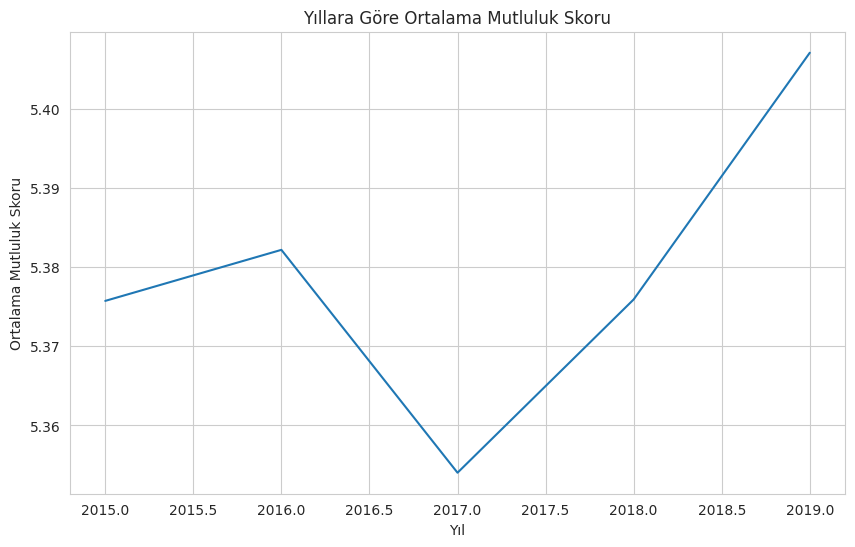

In [9]:
# Yıllara göre mutluluk ortalaması
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Year', y='Score', ci=None)
plt.title('Yıllara Göre Ortalama Mutluluk Skoru')
plt.ylabel('Ortalama Mutluluk Skoru')
plt.xlabel('Yıl')
plt.grid(True)
plt.show()

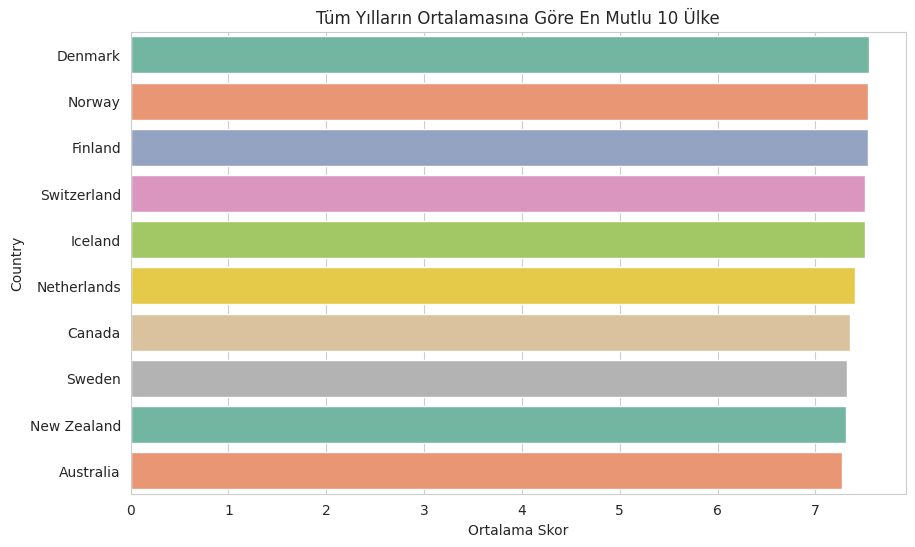

In [38]:
# En mutlu 10 ülke (tüm yılların ortalaması)
top_countries = df.groupby('Country')['Score'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='Set2')
plt.title('Tüm Yılların Ortalamasına Göre En Mutlu 10 Ülke')
plt.xlabel('Ortalama Skor')
plt.show()

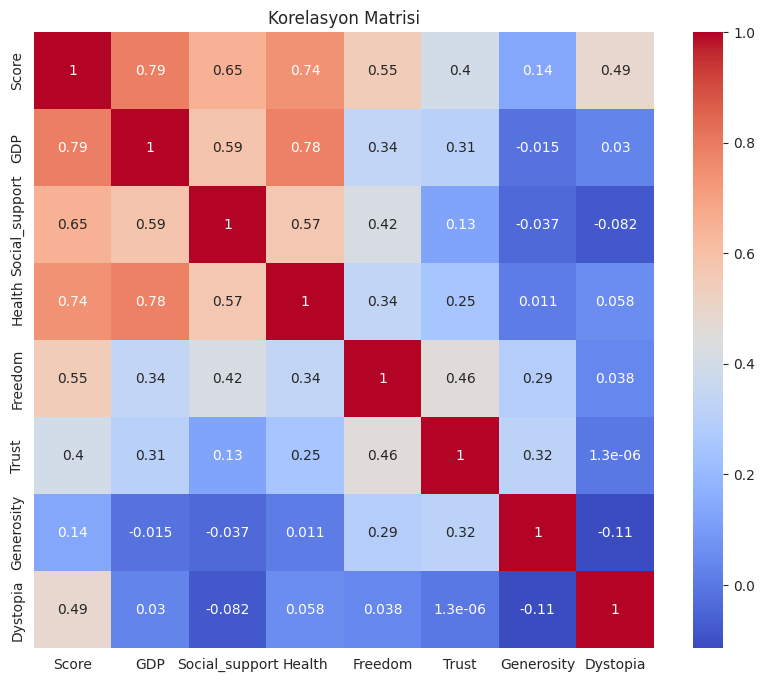

In [12]:
# Korelasyon matrisi
plt.figure(figsize=(10,8))
corr = df.drop(columns=['Year', 'Rank', 'Country']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

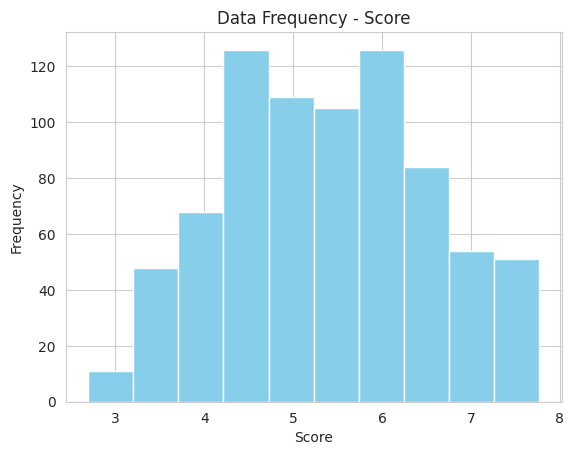

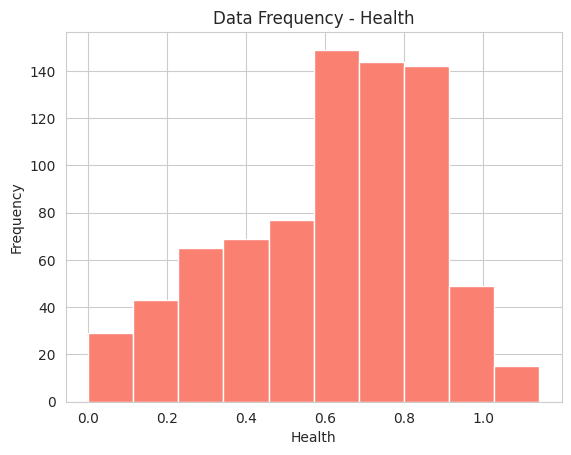

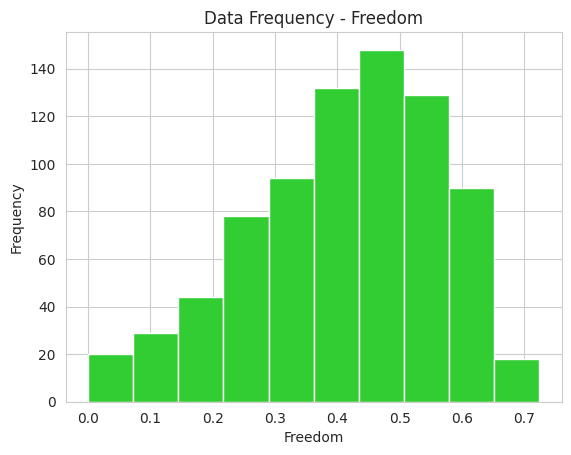

In [36]:
import matplotlib.pyplot as plt

def plotHistogram(variable, color):
    plt.figure()
    plt.hist(df[variable], color=color)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("Data Frequency - {}".format(variable))
    plt.show()

values = ["Score", "Health", "Freedom"]
colors = ["skyblue", "salmon", "limegreen"] 

for variable, color in zip(values, colors):
    plotHistogram(variable, color)


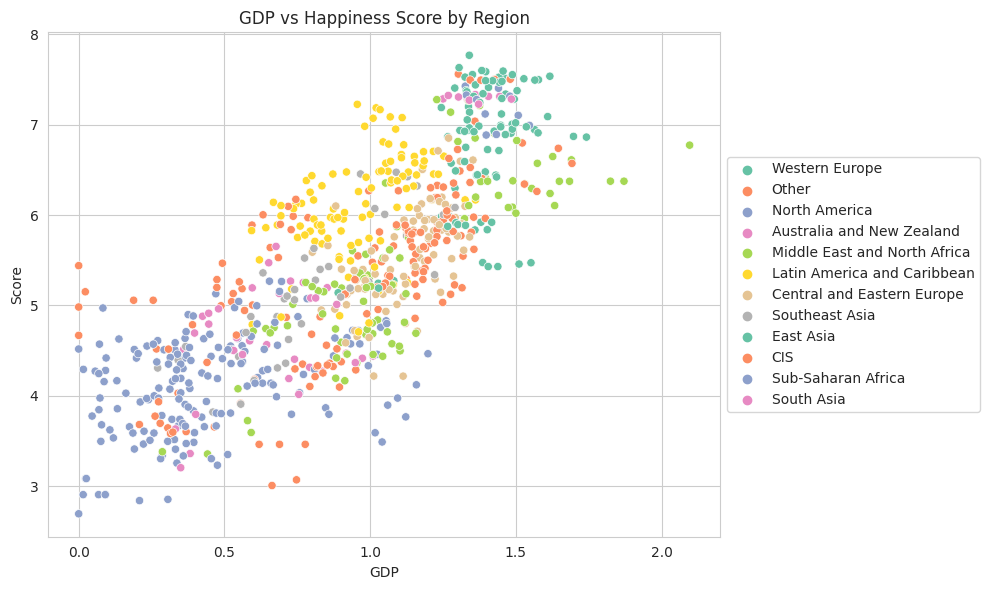

In [20]:
# Ülke -> Bölge eşlemesi
region_map = {
    "Western Europe": ["Switzerland", "Norway", "Denmark", "Netherlands", "Sweden", "Finland", "Germany", "Belgium", "Austria", "Ireland", "Luxembourg", "United Kingdom", "France"],
    "North America": ["United States", "Canada"],
    "Latin America and Caribbean": ["Mexico", "Brazil", "Chile", "Panama", "Uruguay", "Argentina", "Colombia", "Costa Rica", "El Salvador", "Guatemala", "Trinidad and Tobago", "Nicaragua", "Venezuela", "Honduras", "Jamaica", "Dominican Republic", "Ecuador", "Paraguay", "Peru", "Bolivia", "Belize"],
    "Central and Eastern Europe": ["Poland", "Czech Republic", "Slovakia", "Hungary", "Lithuania", "Latvia", "Estonia", "Romania", "Serbia", "Slovenia", "Croatia", "Macedonia", "Bosnia and Herzegovina", "Montenegro", "Bulgaria", "Albania", "Kosovo", "North Macedonia"],
    "CIS": ["Russia", "Ukraine", "Kazakhstan", "Belarus", "Uzbekistan", "Turkmenistan", "Kyrgyzstan", "Moldova", "Armenia", "Azerbaijan", "Georgia"],
    "Middle East and North Africa": ["Israel", "United Arab Emirates", "Qatar", "Saudi Arabia", "Kuwait", "Bahrain", "Oman", "Iran", "Iraq", "Jordan", "Egypt", "Morocco", "Tunisia", "Algeria", "Lebanon", "Palestinian Territories", "Yemen", "Libya"],
    "Sub-Saharan Africa": ["South Africa", "Nigeria", "Kenya", "Ghana", "Zambia", "Zimbabwe", "Uganda", "Cameroon", "Ethiopia", "Tanzania", "Senegal", "Sudan", "Angola", "Namibia", "Botswana", "Mozambique", "Congo (Kinshasa)", "Congo (Brazzaville)", "Mali", "Niger", "Chad", "Rwanda", "Burundi", "Lesotho", "Liberia", "Sierra Leone", "Guinea", "Benin", "Togo", "Gabon", "Central African Republic", "Malawi", "Burkina Faso", "Comoros", "Mauritania", "South Sudan"],
    "South Asia": ["India", "Pakistan", "Bangladesh", "Sri Lanka", "Nepal", "Bhutan", "Afghanistan"],
    "Southeast Asia": ["Thailand", "Vietnam", "Indonesia", "Philippines", "Malaysia", "Myanmar", "Cambodia", "Laos"],
    "East Asia": ["China", "Japan", "South Korea", "Taiwan", "Hong Kong", "Taiwan Province of China", "Hong Kong S.A.R., China"],
    "Australia and New Zealand": ["Australia", "New Zealand"],
    "Other": ["Northern Cyprus", "North Cyprus", "Somalia", "Somaliland Region", "Gambia", "Swaziland"]
}

# Region sütununu oluştur
def assign_region(country):
    for region, countries in region_map.items():
        if country in countries:
            return region
    return "Other"

df["Region"] = df["Country"].apply(assign_region)

# Görselleştirme 1 – Bölgelere göre scatterplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.scatterplot(x="GDP", y="Score", data=df, hue="Region", palette="Set2")
plt.title("GDP vs Happiness Score by Region")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

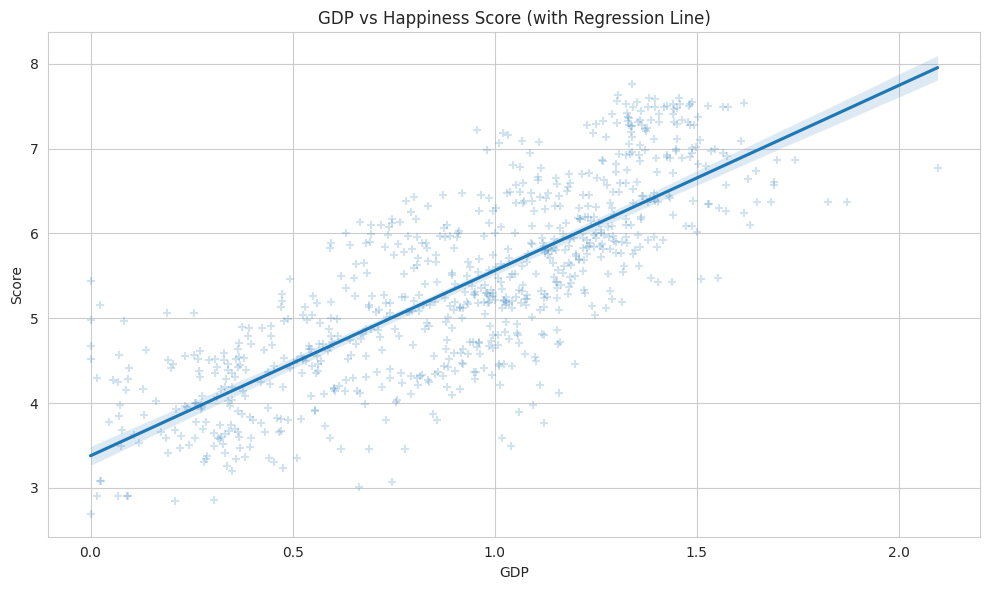

In [21]:
plt.figure(figsize=(10,6))
sns.regplot(x="GDP", y="Score", data=df, marker="+", scatter_kws={"alpha":0.2})
plt.title("GDP vs Happiness Score (with Regression Line)")
plt.tight_layout()
plt.show()

<Axes: >

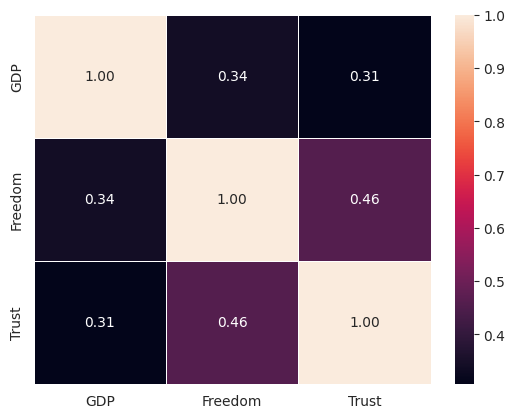

In [24]:
#"GDP", "Freedom", ve "Trust" değişkenlerinin birbirleriyle olan ilişkisi
veri_cor = df.loc[:, ["GDP", "Freedom", "Trust"]]
correlation = veri_cor.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", linewidths=0.5)

# 2.Mutluluk Skorunu Tahmin Etmek için Modelleme (Regresyon)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# NaN olan satırları at (özellikle Trust ve Dystopia bazı yıllarda eksik)
df_model = df.dropna()

X = df_model[['GDP', 'Social_support', 'Health', 'Freedom', 'Trust', 'Generosity']]
y = df_model['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Modeli oluştur ve eğit
model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [28]:
print("R2 Score:", round(r2, 3))
print("RMSE:", round(rmse, 3))

# Model katsayıları
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeff_df)

R2 Score: 0.742
RMSE: 0.574
                Coefficient
GDP                0.930070
Social_support     0.680003
Health             1.284393
Freedom            1.566314
Trust              0.948730
Generosity         0.429528


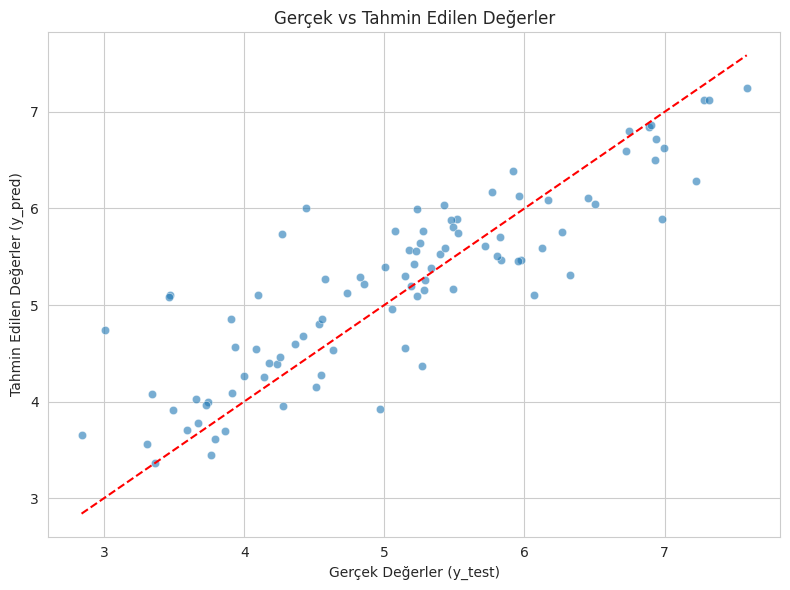

In [29]:
#Gerçek vs Tahmin (Scatter Plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Gerçek Değerler (y_test)")
plt.ylabel("Tahmin Edilen Değerler (y_pred)")
plt.title("Gerçek vs Tahmin Edilen Değerler")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45 derece çizgisi
plt.tight_layout()
plt.show()

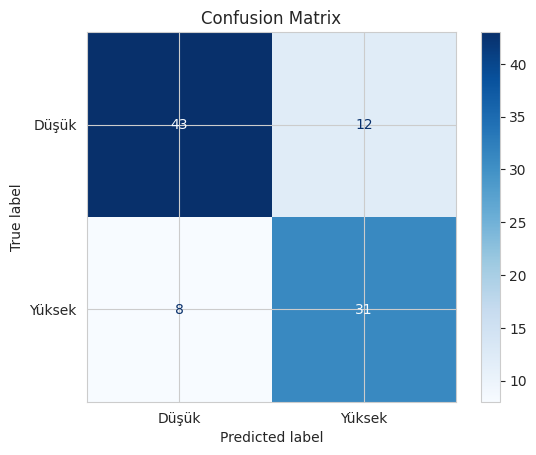

In [34]:
# Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Düşük", "Yüksek"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [35]:
# Precision, Recall, F1 ve diğer metrikler
print(classification_report(y_test, y_pred, target_names=["Düşük", "Yüksek"]))

              precision    recall  f1-score   support

       Düşük       0.84      0.78      0.81        55
      Yüksek       0.72      0.79      0.76        39

    accuracy                           0.79        94
   macro avg       0.78      0.79      0.78        94
weighted avg       0.79      0.79      0.79        94

